In [199]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import matplotlib.pyplot as plt
import random


In [200]:
class SelfAttention(nn.Module):
    
    def __init__(self, d_model, dk, dv):
        super().__init__()
        self.Q = nn.Linear(d_model, dk)
        self.K = nn.Linear(d_model, dk)
        self.V = nn.Linear(d_model, dv)
    
    def forward(self, x):
        dk = self.K.out_features
        gram_matrix = self.Q(x) @ self.K(x).transpose(0, 1)
        scores = nn.Softmax(dim=1)(gram_matrix / math.sqrt(dk))
        self_attention = scores @ self.V(x)
        return self_attention

class MHSA(nn.Module):
    
    def __init__(self, heads, d_model, dk, dv):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(d_model, dk, dv) for _ in range(heads)])
        self.W0 = nn.Linear(heads*dv, d_model)
        
    def forward(self, x):
        heads_output = [head(x) for head in self.heads]
        heads_stack = torch.cat(heads_output, dim=1)
        mhsa = self.W0(heads_stack)
        return mhsa
    
class EncoderLayer(nn.Module):

    def __init__(self, heads, d_model, d_ff, p, dk, dv):
        super().__init__()

        self.attention = MHSA(heads, d_model, dk, dv)
        self.feed_forward = nn.Sequential(nn.Linear(d_model, d_ff),
                                          nn.Tanh(),
                                          nn.Linear(d_ff, d_model))
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        mha = self.attention(x)
        add_norm1 = self.norm1(x + self.dropout(mha))
        fc_output = self.feed_forward(add_norm1)
        add_norm2 = self.norm2(add_norm1 + self.dropout(fc_output))
        return add_norm2

In [201]:
class TransformerPINN(nn.Module):
    
    def __init__(self, input_vars, output_vars, N, heads, d_ff, p, dk, dv):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, input_vars, d_ff, p, dk, dv) for _ in range(N)])
        self.fc_output = nn.Linear(input_vars, output_vars)

    def forward(self, x, y):
        input = torch.cat([x, y], dim=1)
        for layer in self.encoder_layers:
            input = layer(input)
        input = nn.Tanh()(input)
        input = self.fc_output(input)
        return input


class AttentionPINN(nn.Module):
  
  def __init__(self, d_model, d_attn_inner, d_attn_output, d_output):

    super().__init__()

    self.attn1 = SelfAttention(d_model, d_attn_inner, d_attn_inner)
    self.attn2 = SelfAttention(d_attn_inner, d_attn_inner, d_attn_output)
    self.fc = nn.Linear(d_attn_output, d_output)

  def forward(self, x, y):
    input = torch.cat([x, y], dim=1)
    input = nn.GELU()(self.attn1(input))
    input = nn.GELU()(self.attn2(input))
    input = self.fc(input)
    return input


In [202]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

In [203]:
cos, sin, pi = torch.cos, torch.sin, torch.pi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [204]:
x_domain, y_domain = [-pi, pi], [-pi, pi]

def pde(x, y, net):
    u = net(x, y)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_y = derivative(u, y)
    u_yy = derivative(u_y, y)
    return u_xx+ u_yy + 10*cos(x + 2*y)

def boundary_condition(x, y):
    return 2*cos(x + 2*y)


In [205]:
#net = PINN(input_vars=2, output_vars=1, N=4, heads=6, d_ff=100, p=0, dk=10, dv=10)
net = AttentionPINN(d_model=2, d_attn_inner=5, d_attn_output=50, d_output=1)

In [206]:
#net = PINN(input_vars=2, output_vars=1, N=4, heads=6, d_ff=100, p=0, dk=10, dv=10)
net = AttentionPINN(d_model=2, d_attn_inner=20, d_attn_output=70, d_output=1)

samples_boundary, samples_collocation = 2000, 2000
epochs = 8000

losses, nets, optimizers = {}, {}, {}

net.to(device)
optimizers = optim.Adam(net.parameters())
losses = []



def calc_loss():
    u_boundary = net(x_boundary, y_boundary)     
    loss_boundary = nn.MSELoss()(u_boundary, target_boundary)

    pde_collocation = pde(x_collocation, y_collocation, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
    
    return loss_collocation + loss_boundary

def closure():
    optimizers.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

try:
  for epoch in range(1, epochs + 1):

    # Data generation:
    x_boundary = torch.empty(samples_boundary, 1, device=device).uniform_(*x_domain)
    y_boundary = torch.empty(samples_boundary, 1, device=device).uniform_(*y_domain)

    for n_sample in range(samples_boundary):
        set_var = random.choice([0, 1])
        x_boundary[n_sample, 0] = random.choice(x_domain) if set_var == 0 else random.uniform(*x_domain)
        y_boundary[n_sample, 0] = random.choice(y_domain) if set_var == 1 else random.uniform(*y_domain)

    target_boundary = boundary_condition(x_boundary, y_boundary)

    x_collocation = torch.empty(samples_collocation, 1, device=device).uniform_(*x_domain).requires_grad_()
    y_collocation = torch.empty(samples_collocation, 1, device=device).uniform_(*y_domain).requires_grad_()
    target_collocation = torch.zeros(samples_collocation, 1, device=device)

    # Training:
    optimizers.step(closure)
    loss = calc_loss().item()
    if epoch % 100 == 0:
      print(f'Epoch: {epoch} - loss: {loss}')
    losses.append(loss)
except KeyboardInterrupt:
  pass

Epoch: 100 - loss: 45.46328353881836
Epoch: 200 - loss: 20.254688262939453
Epoch: 300 - loss: 18.36998176574707
Epoch: 400 - loss: 15.958542823791504
Epoch: 500 - loss: 14.044380187988281
Epoch: 600 - loss: 14.068785667419434
Epoch: 700 - loss: 10.344537734985352
Epoch: 800 - loss: 10.477113723754883
Epoch: 900 - loss: 10.730175971984863
Epoch: 1000 - loss: 9.467716217041016
Epoch: 1100 - loss: 10.576520919799805
Epoch: 1200 - loss: 9.65617561340332
Epoch: 1300 - loss: 8.29330825805664
Epoch: 1400 - loss: 9.40867805480957
Epoch: 1500 - loss: 8.614184379577637
Epoch: 1600 - loss: 7.597615718841553
Epoch: 1700 - loss: 6.488040447235107
Epoch: 1800 - loss: 6.953897953033447
Epoch: 1900 - loss: 9.091598510742188
Epoch: 2000 - loss: 6.056046962738037
Epoch: 2100 - loss: 5.954331398010254
Epoch: 2200 - loss: 4.753817558288574
Epoch: 2300 - loss: 5.056840419769287
Epoch: 2400 - loss: 4.762240409851074
Epoch: 2500 - loss: 5.642351150512695
Epoch: 2600 - loss: 5.582487106323242
Epoch: 2700 - lo

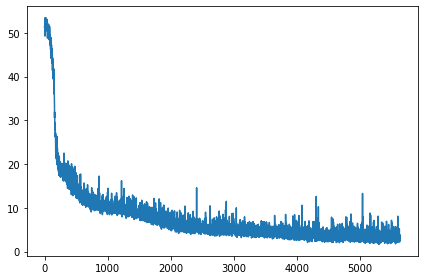

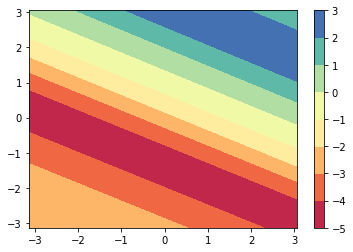

In [207]:
# Loss:
epochs_range = torch.arange(1, len(losses) + 1, 1)
plt.plot(epochs_range, losses)

plt.tight_layout()
plt.show()

# Prediction:
x = torch.arange(*x_domain, 1e-1)
y = torch.arange(*y_domain, 1e-1)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
input = grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)

net.to('cpu')
net.eval()
u_pred = net(*input).detach()
net.to(device)
simulation = plt.contourf(grid_x, grid_y, u_pred.reshape_as(grid_x), cmap='Spectral')
plt.colorbar(simulation)
plt.show()